## 🎬 Netflix Dataset EDA

This notebook explores the **Netflix Movies and TV Shows dataset** to uncover insights about content trends, genres, countries, and release patterns.  
The analysis includes:

- Data cleaning and preparation  
- Distribution of Movies vs TV Shows  
- Most common genres, directors, and actors  
- Trends over time (release year vs date added)   
- Duration analysis for Movies and TV Shows  
- Text analysis of show descriptions  

The goal is to **understand how Netflix’s catalog has evolved** and highlight interesting patterns in its global content.


### Setup & Data Import
This section imports all necessary libraries and loads the dataset. The code includes error handling to ensure the file is found and some initial checks to get a quick overview of the data.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import re

# Set plotting styles for a consistent look
sns.set_style("whitegrid")
plt.style.use('ggplot')


# Load the dataset
try:
    df = pd.read_csv("data/netflix_data.csv")
except FileNotFoundError:
    print("Error: The file 'netflix_data.csv' was not found. Please check the file path.")
    # Exit or handle the error gracefully
    exit()

# Print basic info
print(f"Shape of the dataset: {df.shape}")
print("\n--- Column Info ---")
df.info()

print("\n--- First 5 rows ---")
display(df.head())

Shape of the dataset: (4812, 11)

--- Column Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       4812 non-null   object
 1   type          4812 non-null   object
 2   title         4812 non-null   object
 3   director      4812 non-null   object
 4   cast          4812 non-null   object
 5   country       4812 non-null   object
 6   date_added    4812 non-null   object
 7   release_year  4812 non-null   int64 
 8   duration      4812 non-null   int64 
 9   description   4812 non-null   object
 10  genre         4812 non-null   object
dtypes: int64(2), object(9)
memory usage: 413.7+ KB

--- First 5 rows ---


,show_id,type,title,director,cast,country,date_added,release_year,duration,description,genre
0,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,93,After a devastating earthquake hits Mexico Cit...,Dramas
1,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,78,"When an army recruit is found dead, his fellow...",Horror Movies
2,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,80,"In a postapocalyptic world, rag-doll robots hi...",Action
3,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,123,A brilliant group of students become card-coun...,Dramas
4,s6,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,"July 1, 2017",2016,1,A genetics professor experiments with a treatm...,International TV


### Data Cleaning and Preparation
Since our dataset has no missing values, we can simplify the cleaning process. This section focus on converting the `date_added` column to the correct format and separating the data into Movies and TV shows for individual analysis. This is an essential step to ensure the data types are correct for plotting and statistical calculations.

In [61]:
# --- Main Cleaning Steps ---

# Missing values
print('\n--- Missing values ---')
print(df.isnull().sum())

# Remove duplicates
df.drop_duplicates(inplace=True)

# Convert 'date_added' to datetime and extract the year.
df['date_added'] = pd.to_datetime(df['date_added'].str.strip())
df['year_added'] = df['date_added'].dt.year

# Separate movies and tv shows into two different DataFrames.
# We use .copy() to ensure we are working on a new DataFrame slice
movies_df = df[df['type'] == 'Movie'].copy()
tv_shows_df = df[df['type'] == 'TV Show'].copy()

print("\n--- Data Cleaning Complete ---")
print(f"Cleaned Movies DataFrame shape: {movies_df.shape}")
print(f"Cleaned TV Shows DataFrame shape: {tv_shows_df.shape}")


--- Missing values ---
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
duration        0
description     0
genre           0
dtype: int64

--- Data Cleaning Complete ---
Cleaned Movies DataFrame shape: (4677, 12)
Cleaned TV Shows DataFrame shape: (135, 12)


### Basic Descriptive Analysis

To build an overall understanding of the dataset, we start with some **descriptive statistics and visual exploration**.  
This step highlights the general structure of Netflix’s catalog and helps identify patterns worth deeper analysis later.

- Number of Movies vs TV Shows  
- Most Common Countries
- Most Frequent Genres
- Top Directors  
- Distribution of Release Years 

#### Movies vs TV Shows
 - Compare the total number of Movies and TV Shows available.  
 - Identify whether Netflix’s library is more film-focused or series-focused.

In [62]:
type_counts = df['type'].value_counts().reset_index()
type_counts.columns = ['Type', 'Count']

fig = px.bar(
    type_counts,
    x='Type',
    y='Count',
    title='Movies vs. TV Shows Distribution on Netflix',
    color='Type',
    labels={'Type': 'Content Type', 'Count': 'Number of Titles'},
    template='plotly_white'
)
fig.show()

*Interpretation: The plot clearly shows that Netflix's library is heavily dominated by movies, which outnumber TV shows by a significant margin.*

#### Country Distribution
- Find out which countries contribute the most titles.  
- Spot regional differences in content production.  

In [63]:
country_counts = df['country'].value_counts().head(10).reset_index()
country_counts.columns = ['Country', 'Count']

fig = px.bar(
    country_counts,
    x='Count',
    y='Country',
    orientation='h',
    title='Top 10 Countries by Content Contribution',
    color='Count',
    labels={'Country': 'Country', 'Count': 'Number of Titles'},
    template='plotly_white'
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

*Interpretation: The United States is by far the largest contributor, with a massive lead over other countries. This suggests a strong focus on American content, with India and the UK also being significant producers.*

##### Movies vs. TV Shows by Country (Top 10)

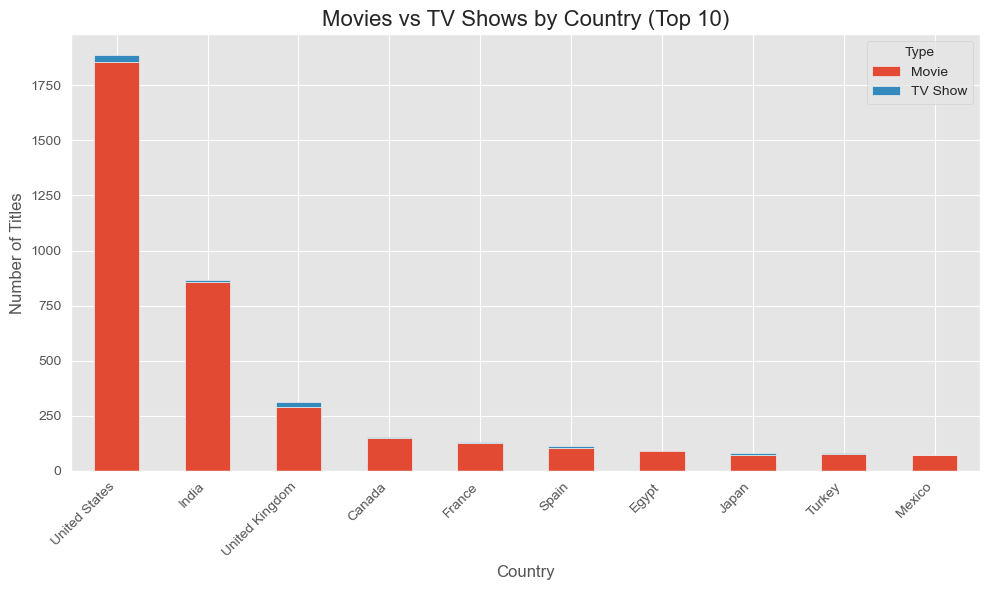

In [64]:
country_type = df.groupby(['country','type']).size().unstack(fill_value=0)
top_countries_type = country_type.sum(axis=1).sort_values(ascending=False).head(10).index
country_type_top = country_type.loc[top_countries_type]

country_type_top.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Movies vs TV Shows by Country (Top 10)", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of Titles", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Type")
plt.tight_layout()
plt.show()


*Interpretation: While the United States contributes the most titles overall, its library is predominantly movies. In contrast, countries like the UK and Japan have a more balanced mix, with a noticeable number of TV shows.*

#### Genre Popularity
- Explore the most frequent genres across Netflix.  
- Identify dominant themes such as Drama, Comedy, Documentary, etc. 


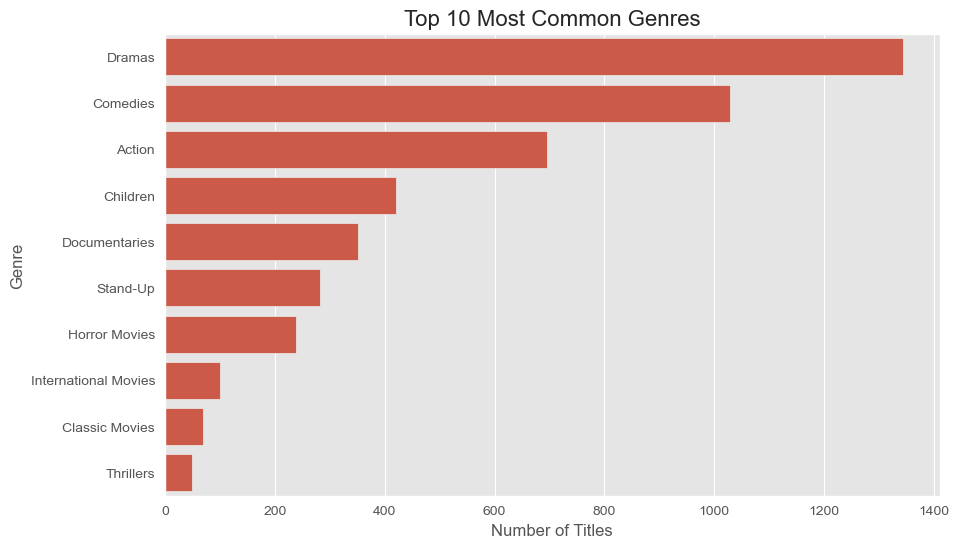

In [65]:
# A single title can have multiple genres, so we'll need to split and count each one.
# First, create a new series by splitting the 'genre' column by comma
all_genres = df['genre'].str.split(', ').explode()
genre_counts = all_genres.value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=genre_counts.index, x=genre_counts.values)
plt.title('Top 10 Most Common Genres', fontsize=16)
plt.xlabel('Number of Titles', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.show()

*Interpretation: The plot reveals that Dramas and Comedies are the most common genres in the dataset. This highlights the platform's focus on these broad and popular categories.*

#### Directors and Cast
- Explore the most frequent genres across Netflix.  
- Identify dominant themes such as Drama, Comedy, Documentary, etc. 

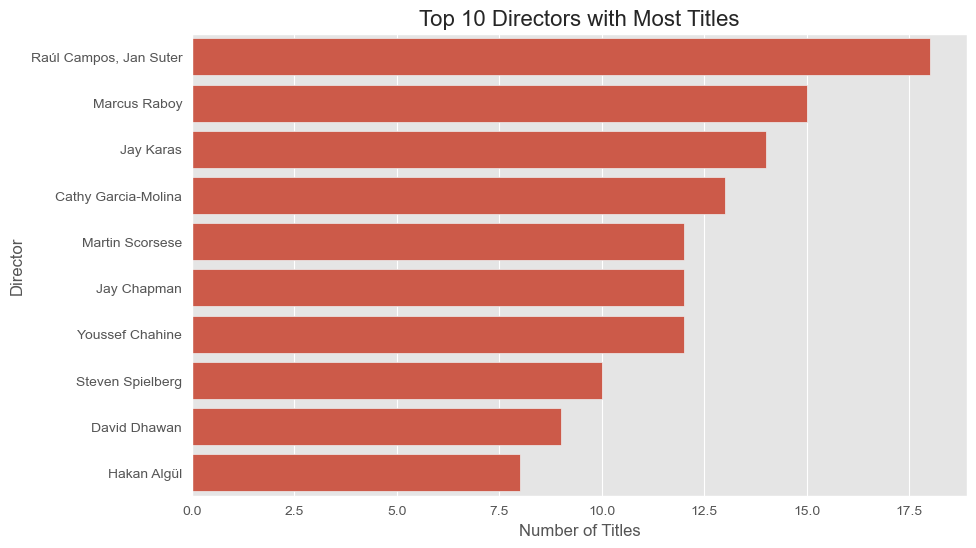

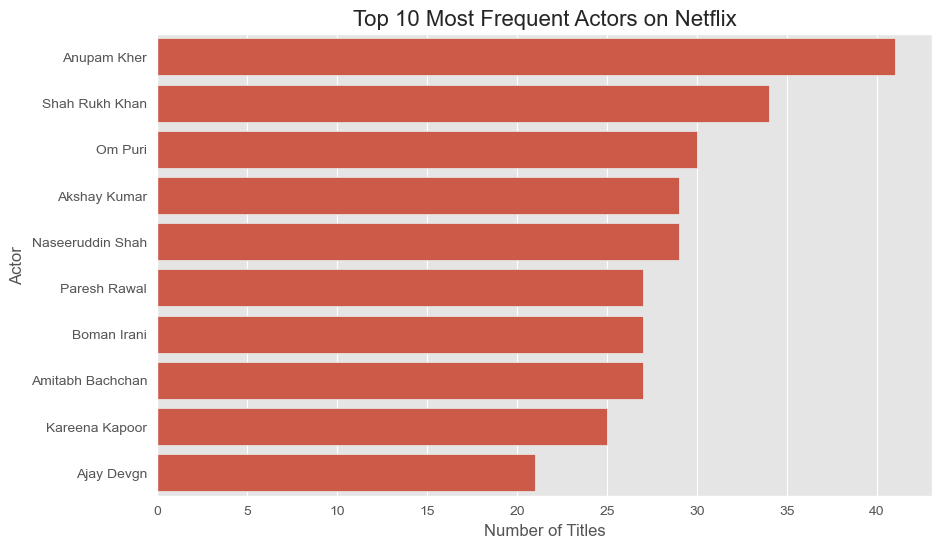

In [66]:
# --- Top 10 directors ---
top_directors = df['director'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_directors.index, x=top_directors.values)
plt.title("Top 10 Directors with Most Titles", fontsize=16)
plt.xlabel("Number of Titles", fontsize=12)
plt.ylabel("Director", fontsize=12)
plt.show()

# --- Top 10 Actors ---
# First, split the 'cast' column to count each actor's appearance
all_actors_list = df['cast'].str.split(', ').explode()
actor_counts = all_actors_list.value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=actor_counts.index, x=actor_counts.values)
plt.title("Top 10 Most Frequent Actors on Netflix", fontsize=16)
plt.xlabel("Number of Titles", fontsize=12)
plt.ylabel("Actor", fontsize=12)
plt.show()

*Interpretation: The bar chart for directors highlights a few individuals who have created a large number of titles, with Raul Campos leading the way. The actor chart, after splitting the cast list, shows that a few key actors, such as Anupam Kher, have appeared in a high number of titles, often indicating a focus on specific regional content (e.g., Bollywood films).*

#### Distribution of Release Years
- Analyse how the number of releases changes across years.  
- Detect peaks or declines in content production trends.  

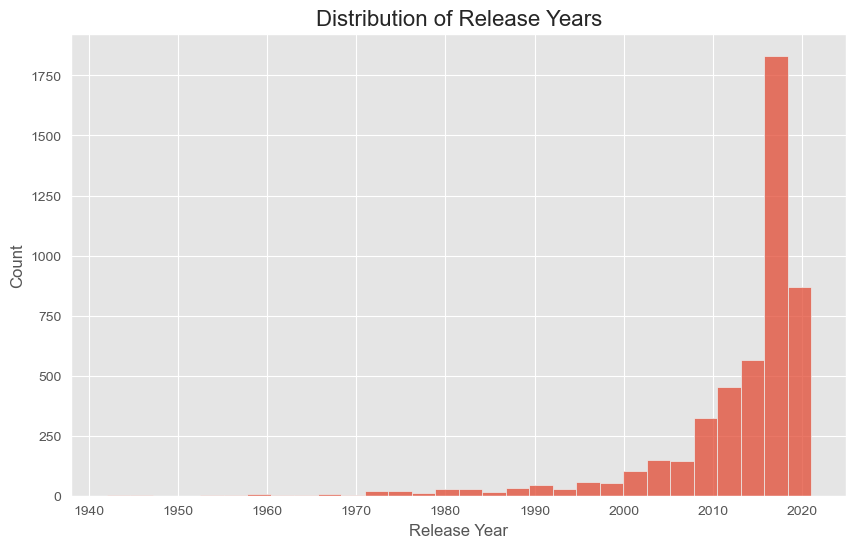

In [67]:
plt.figure(figsize=(10, 6))
sns.histplot(df['release_year'], bins=30, kde=False)
plt.title("Distribution of Release Years", fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()



*Interpretation: The plot shows a clear surge in titles released in recent years, with a sharp increase after 2000 and a significant peak in the late 2010s. This confirms that Netflix's catalog is heavily focused on modern and contemporary content, with a smaller number of titles from older decades*

### Time-based Analysis
Understanding how Netflix’s catalog has evolved over time provides insights into the platform’s growth strategy and content acquisition patterns.  

- Titles Added Per Year
- Release Year vs Date Added
- Growth of the Netflix Catalog

#### Titles Added Per Year
- Track how many titles were added to Netflix each year.  
- Helps identify the years of fastest catalog growth.  

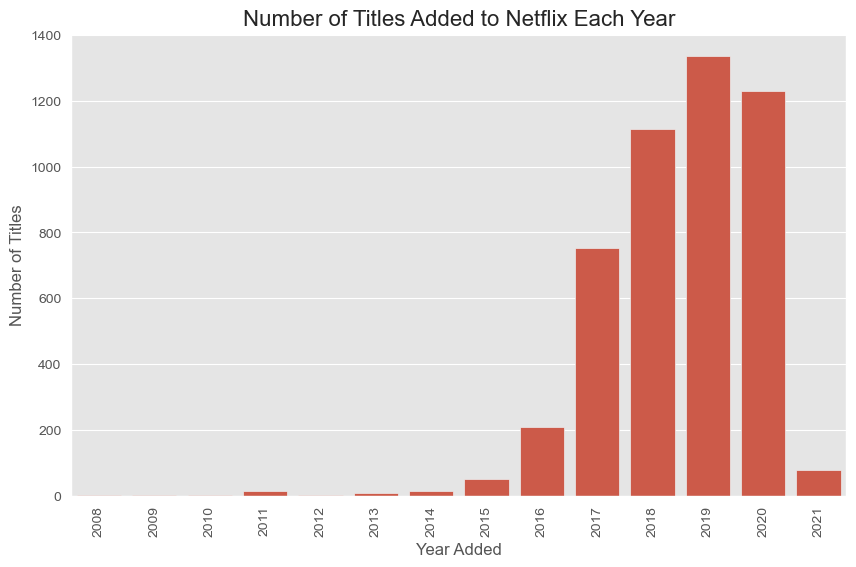

In [68]:
# --- Titles added to Netflix per year ---

plt.figure(figsize=(10, 6))
sns.countplot(x='year_added', data=df, order=sorted(df['year_added'].dropna().unique()))
plt.xticks(rotation=90)
plt.title("Number of Titles Added to Netflix Each Year", fontsize=16)
plt.xlabel("Year Added", fontsize=12)
plt.ylabel("Number of Titles", fontsize=12)
plt.show()

*Interpretation: The number of titles added to Netflix peaked in 2019 and 2020. There is a noticeable drop in the most recent year, which could be due to a change in data collection or a shift in the platform's content strategy.*

##### Movies vs. TV Shows Added Per Year

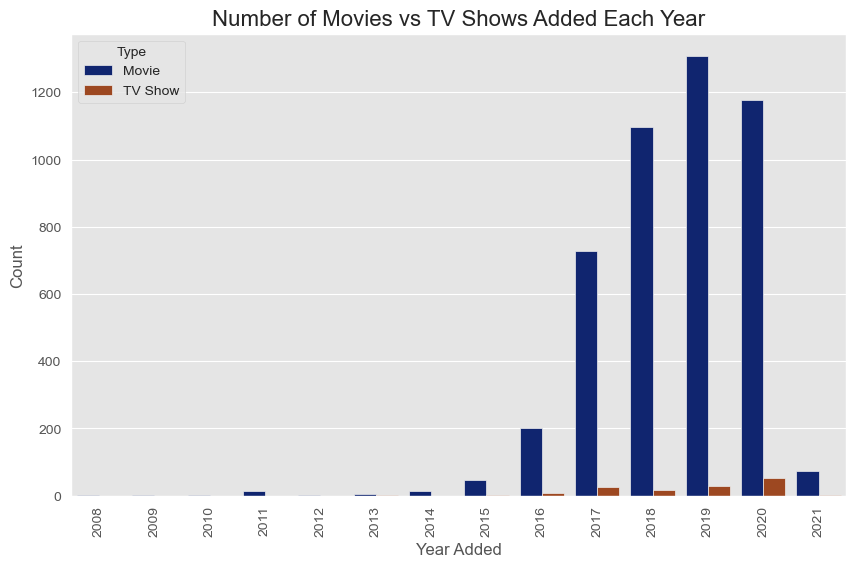

In [69]:
plt.figure(figsize=(10, 6))
sns.countplot(x='year_added', hue='type', data=df, order=sorted(df['year_added'].dropna().unique()), palette='dark')
plt.xticks(rotation=90)
plt.title("Number of Movies vs TV Shows Added Each Year", fontsize=16)
plt.xlabel("Year Added", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Type")
plt.show()

*Interpretation: The plot shows that the overall growth in titles from 2016 to 2019 was driven primarily by an increase in the number of movies added. While TV show additions also grew, they remained a smaller portion of the total. This reinforces the finding that Netflix's library is heavily movie-focused.*

#### Release Year vs Date Added
 - Compare when a title was originally released with the year it was added to Netflix.  
 - This shows whether Netflix focuses more on **new releases** or on acquiring **older content**.  


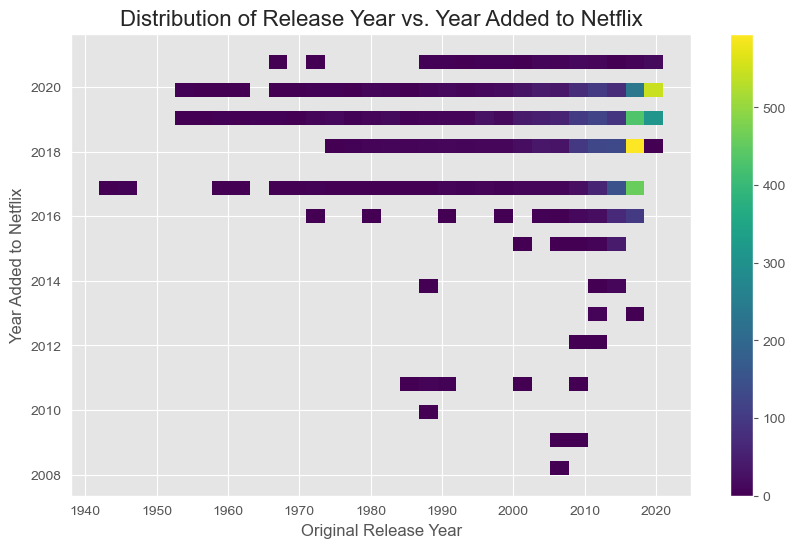

In [58]:
# --- Compare release year vs. date added ---

plt.figure(figsize=(10, 6))
sns.histplot(
    x='release_year',
    y='year_added',
    data=df,
    cmap='viridis',
    bins=(30, 30),
    cbar=True
)
plt.title('Distribution of Release Year vs. Year Added to Netflix', fontsize=16)
plt.xlabel('Original Release Year', fontsize=12)
plt.ylabel('Year Added to Netflix', fontsize=12)
plt.show()

*Interpretation: The plot shows a strong diagonal trend, indicating that most content is added to Netflix in the same year or shortly after its original release. However, there is a notable cluster of older content being added in recent years (visible in the lower-right area of the plot), suggesting that Netflix is also acquiring a significant number of older titles to fill out its library.*

#### Top Genres by Year
This stacked bar chart shows the distribution of the top 10 genres over time, allowing us to see which genres grew in popularity and when.



<Figure size 1200x800 with 0 Axes>

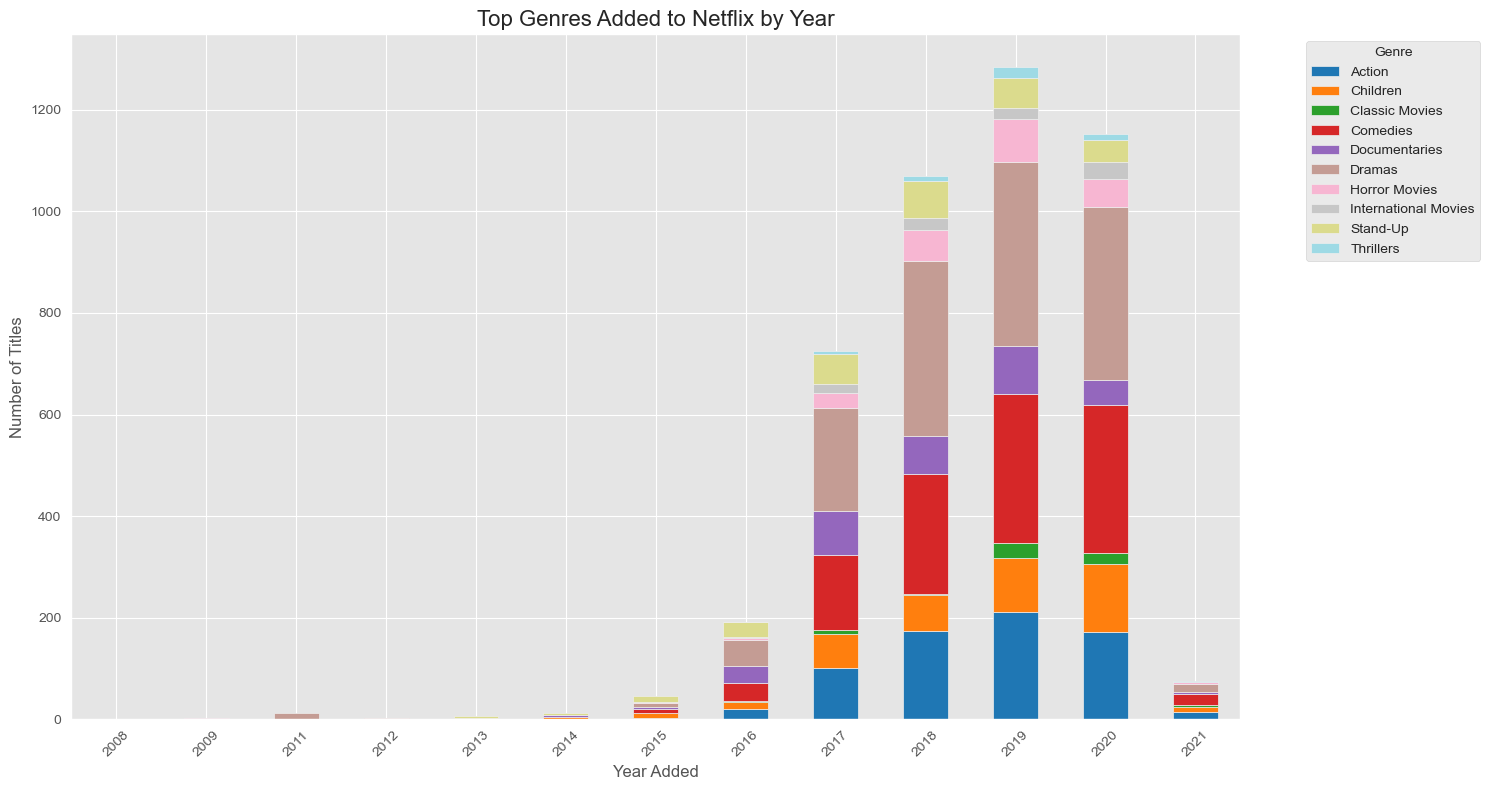

In [88]:
# Create a new DataFrame with one row per genre per title.
df_genres = df.assign(listed_in=df['genre'].str.split(', ')).explode('genre')

# Get the top 10 genres to keep the plot readable.
top_10_genres = df_genres['genre'].value_counts().head(10).index

# Filter the DataFrame to only include these top genres.
df_top_genres = df_genres[df_genres['genre'].isin(top_10_genres)]

# Create a pivot table to count the number of titles per year per genre.
genre_by_year = df_top_genres.groupby(['year_added', 'genre']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
genre_by_year.plot(kind='bar', stacked=True, figsize=(15, 8), cmap='tab20')
plt.title("Top Genres Added to Netflix by Year", fontsize=16)
plt.xlabel("Year Added", fontsize=12)
plt.ylabel("Number of Titles", fontsize=12)
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Interpretation: The plot shows a dramatic increase in International Movies, Dramas, and Comedies being added in the most recent years. This highlights Netflix's strategic move to acquire more content from outside the US and to focus on universally popular genres like drama and comedy.*

#### Growth of the Netflix Catalog
- Measure the cumulative number of titles available over time.  
- Reveals how quickly Netflix expanded its library and if growth is slowing down or accelerating in recent years.  

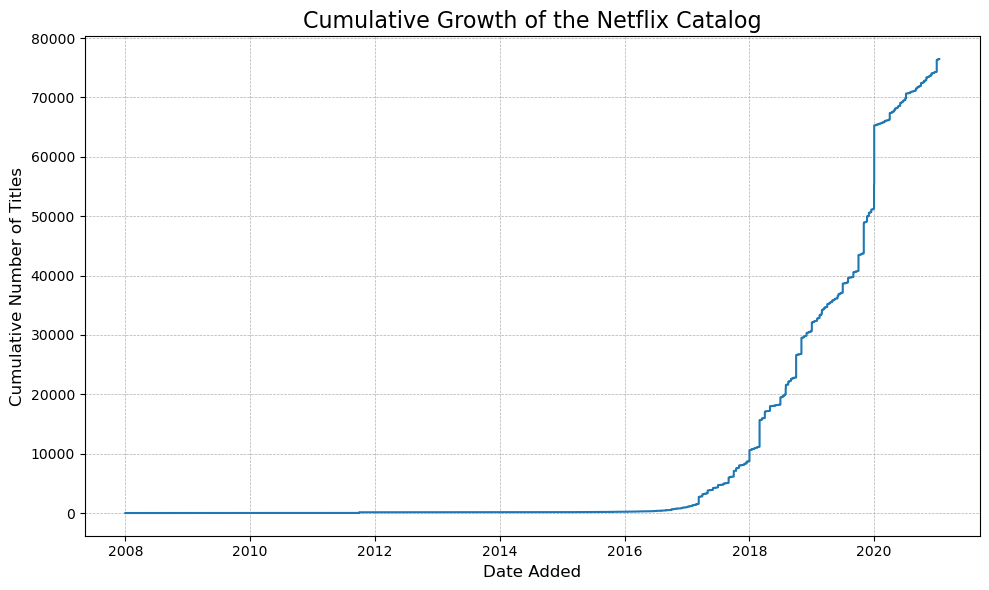

In [173]:
# Sort the DataFrame by the date added. This is essential for a correct cumulative sum.
df.sort_values('date_added', inplace=True)

# Calculate the cumulative count of titles over time.
# We first group by the date and count the number of titles added each day.
# Then, we apply the cumsum() function to get the running total.
df['cumulative_titles'] = df.groupby('date_added')['show_id'].transform('count').cumsum()

# Create the line plot.
plt.figure(figsize=(10, 6))
plt.plot(df['date_added'], df['cumulative_titles'], marker='', linestyle='-')
plt.title('Cumulative Growth of the Netflix Catalog', fontsize=16)
plt.xlabel('Date Added', fontsize=12)
plt.ylabel('Cumulative Number of Titles', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

*Interpretation: The plot displays a clear and accelerating growth curve, especially from 2015 onwards. The steep increase in the number of titles added in recent years indicates that Netflix's catalog expanded rapidly, likely as the platform shifted from being a DVD rental service to a content-streaming giant.*

### Duration & Format Insights
Analysing the length of Movies and the number of seasons of TV Shows provides insights into how Netflix structures its content.  
Some content may be unusually short (e.g., short films) or unusually long (e.g., extended specials or multi-season series).  

- Distribution of Movie Durations
- TV Show Seasons

#### Distribution of Movie Durations
  - Explore how long most Netflix movies are.  
  - Identify typical ranges (e.g., 90–120 minutes is common for feature films).  
  - Detect outliers such as unusually short or long movies.   

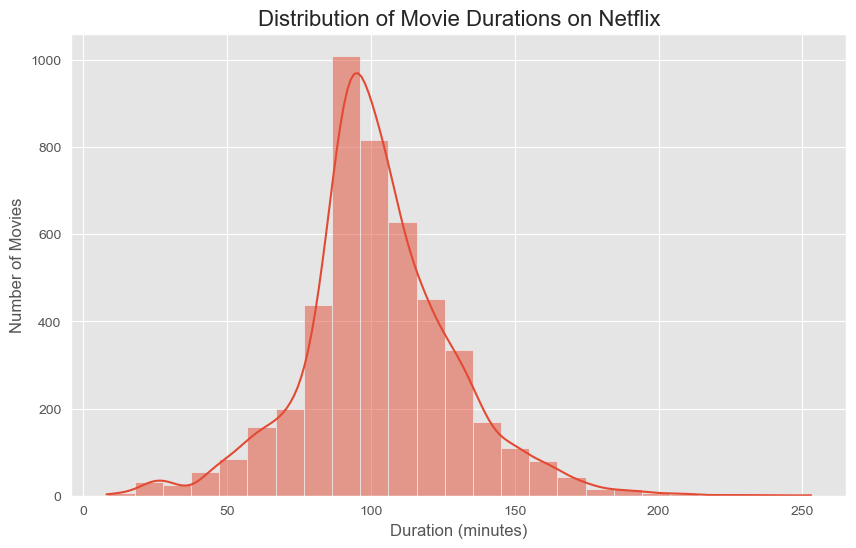


--- Movie Duration Statistics ---
Average movie duration: 102.38 minutes
Median movie duration: 100.0 minutes
Most common duration: 93 minutes


In [74]:
plt.figure(figsize=(10, 6))
sns.histplot(
    movies_df['duration'],
    bins=25,
    kde=True
)
plt.title("Distribution of Movie Durations on Netflix", fontsize=16)
plt.xlabel("Duration (minutes)", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.show()

print("\n--- Movie Duration Statistics ---")
print(f"Average movie duration: {movies_df['duration'].mean():.2f} minutes")
print(f"Median movie duration: {movies_df['duration'].median()} minutes")
print(f"Most common duration: {movies_df['duration'].mode()[0]} minutes")

*Interpretation: The plot reveals a clear peak around the 90-110 minute mark, which is the typical duration for a feature film. There is also a secondary, smaller peak for shorter content, likely representing documentaries, stand-up specials, or short films.*

#### TV Show Seasons

- Examine how many seasons most TV Shows have.  
- Identify whether Netflix favors limited series (1–2 seasons) or longer-running shows.  

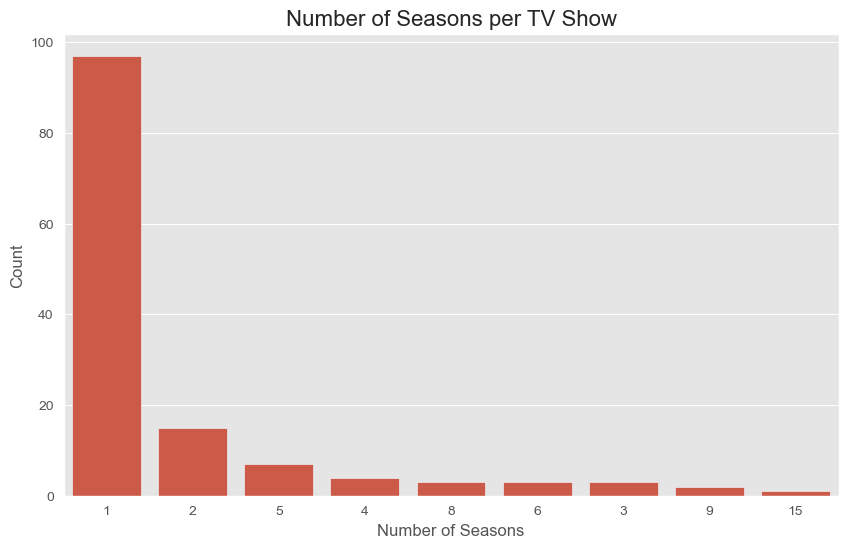


--- TV Show Seasons Statistics ---
Average number of seasons: 1.94
Most common number of seasons: 1


In [76]:
plt.figure(figsize=(10, 6))
sns.countplot(
    x='duration',
    data=tv_shows_df,
    order=tv_shows_df['duration'].value_counts().index
)
plt.title("Number of Seasons per TV Show", fontsize=16)
plt.xlabel("Number of Seasons", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

print("\n--- TV Show Seasons Statistics ---")
print(f"Average number of seasons: {tv_shows_df['duration'].mean():.2f}")
print(f"Most common number of seasons: {tv_shows_df['duration'].mode()[0]}")

*Interpretation: Netflix's library is dominated by single-season TV shows, which suggests a strong focus on limited series. The number of shows drops off dramatically after two seasons, indicating that Netflix may favor producing or acquiring shorter-form series over long-running ones.*

In [78]:
# Top 10 longest-running TV Shows
top_tv_shows = tv_shows_df[['title', 'duration']].sort_values(by="duration", ascending=False).head(10)
top_tv_shows

,title,duration
3678,Supernatural,15
2758,Naruto,9
783,Call the Midwife,9
3292,Royal Pains,8
3996,The Great British Baking Show,8
403,Arrow,8
1339,Father Brown,6
945,Comedians in Cars Getting Coffee,6
3962,The Flash,6
1449,Fullmetal Alchemist: Brotherhood,5


#### Average Movie and TV Show Length Over Time
This plot compares the average duration of movies (in minutes) and the average number of seasons for TV shows added to Netflix each year.

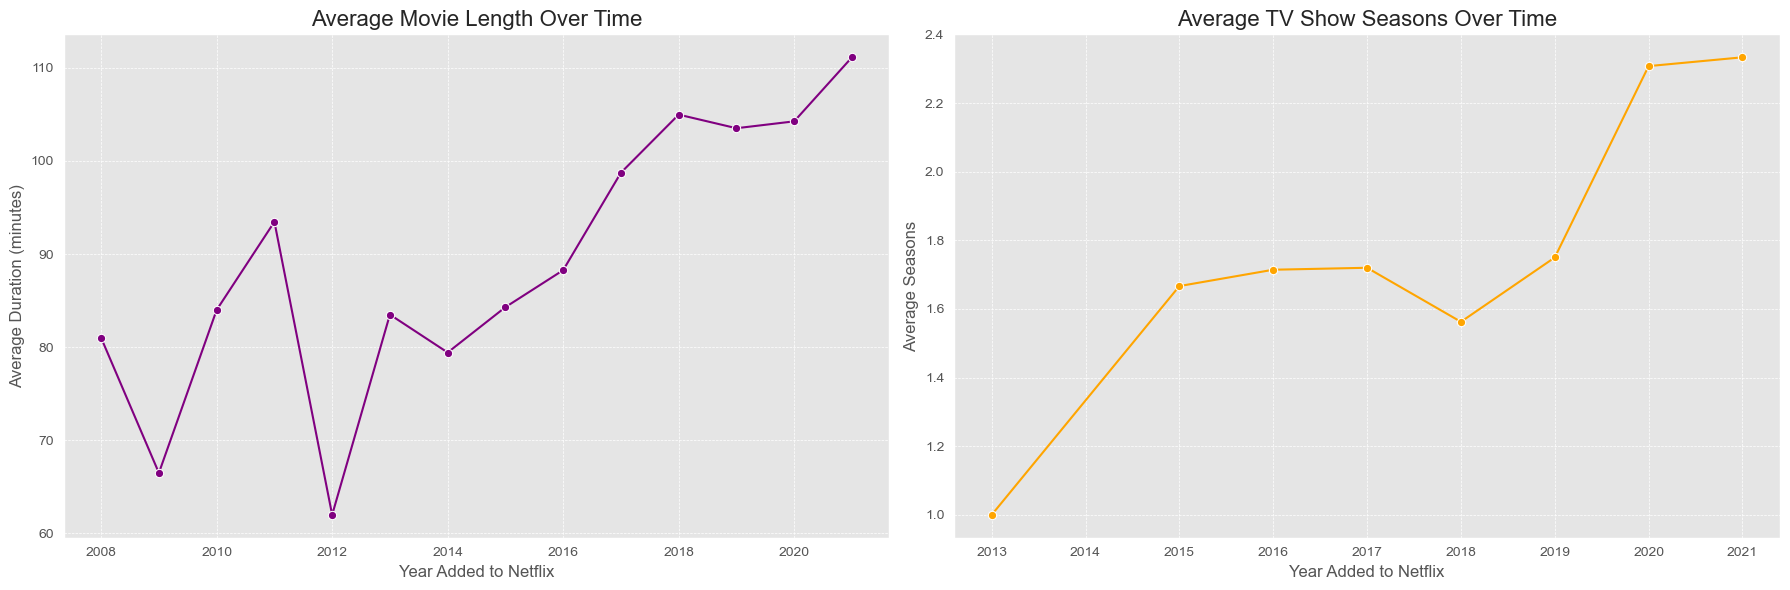

In [92]:
# Calculate the average movie duration per year added
avg_movie_length = movies_df.groupby('year_added')['duration'].mean().reset_index()

# Calculate the average TV show seasons per year added
avg_tv_show_length = tv_shows_df.groupby('year_added')['duration'].mean().reset_index()

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the average movie length on the first subplot
sns.lineplot(
    data=avg_movie_length,
    x='year_added',
    y='duration',
    marker='o',
    linestyle='-',
    color='purple',
    ax=axes[0]
)
axes[0].set_title('Average Movie Length Over Time', fontsize=16)
axes[0].set_xlabel('Year Added to Netflix', fontsize=12)
axes[0].set_ylabel('Average Duration (minutes)', fontsize=12)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot the average TV show seasons on the second subplot
sns.lineplot(
    data=avg_tv_show_length,
    x='year_added',
    y='duration',
    marker='o',
    linestyle='-',
    color='orange',
    ax=axes[1]
)
axes[1].set_title('Average TV Show Seasons Over Time', fontsize=16)
axes[1].set_xlabel('Year Added to Netflix', fontsize=12)
axes[1].set_ylabel('Average Seasons', fontsize=12)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust the overall layout to prevent labels from overlapping
plt.tight_layout()
plt.show()

*Interpretation:*
- *The average movie length has remained relatively stable over the years, fluctuating around 90-100 minutes.*
- *The average TV show length (seasons), on the other hand, shows a distinct trend. A sharp drop is visible after 2017, indicating that Netflix has increasingly added single-season content, such as limited series and original miniseries, as part of its content strategy.*

*This side-by-side comparison reveals a key difference in content trends: while movie lengths have stayed consistent, TV shows have become shorter, with a strong emphasis on single-season formats.*

### Text Analysis of Show Descriptions
The `description` column contains short text summaries of each show.  
By analysing this text, we can discover common themes, genres, and patterns in Netflix’s catalog. 

- Word cloud of show descriptions
- Keyword frequency

#### Word Cloud of Descriptions
- Visualise the most common words across all show descriptions.  
- Helps spot recurring themes (e.g., "love", "family", "murder", "friendship").  

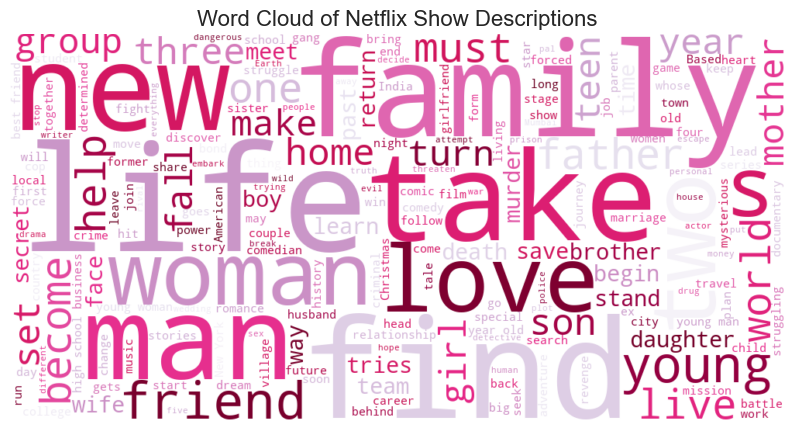

In [79]:
text = " ".join(df['description'].astype(str))

wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    stopwords=set(STOPWORDS),
    colormap='PuRd'
).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Netflix Show Descriptions", fontsize=16)
plt.show()

*Interpretation: The most prominent words include "new", "life", "family", and "take". This highlights a focus on themes of personal relationships, drama, and global narratives across the content library.*

#### Keyword Frequency
  - Count and rank the most frequent words.  
  - Identify dominant topics and genre-related terms in Netflix’s catalog.  

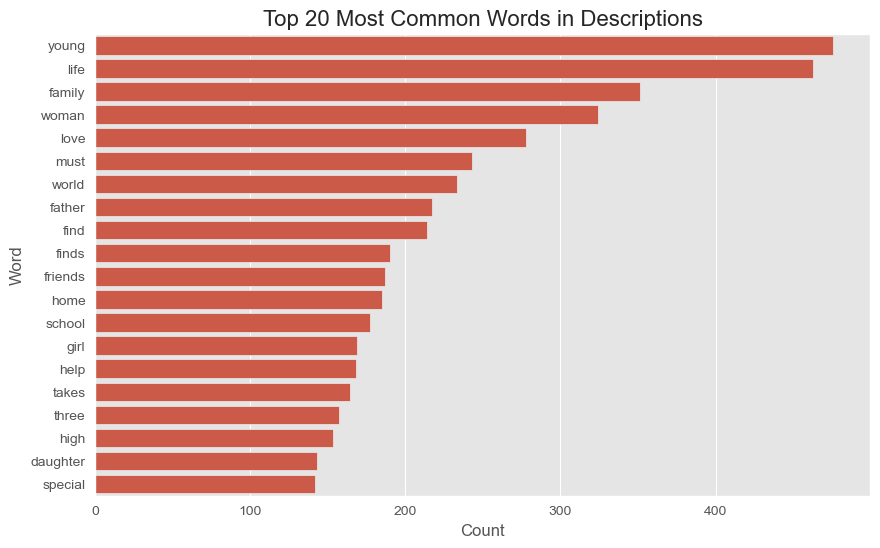

In [82]:
text = " ".join(df['description'].astype(str))

words = re.findall(r'\b\w{4,}\b', text.lower())
stopwords = set(STOPWORDS)
filtered_words = [w for w in words if w not in stopwords]

word_freq = Counter(filtered_words).most_common(20)

word_freq_df = pd.DataFrame(word_freq, columns=['word', 'count'])

plt.figure(figsize=(10, 6))
sns.barplot(y='word', x='count', data=word_freq_df)
plt.title("Top 20 Most Common Words in Descriptions", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Word", fontsize=12)
plt.show()

*Interpretation: The top words confirm the findings of the word cloud, with words like "story", "life", "young", "family", and "love" dominating. These keywords suggest that dramas, coming-of-age stories, and family-focused narratives are prevalent genres on Netflix.*